In [26]:
import warnings
warnings.filterwarnings('ignore')

import pymongo
from pymongo import MongoClient
client = MongoClient()

import numpy as np

import pandas as pd
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 5000)
pd.set_option('display.width', 1000)

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error, median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit 

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
%matplotlib inline

import seaborn as sns
sns.set()

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm

import scipy.stats as scs
from scipy.optimize import minimize

from dateutil.relativedelta import relativedelta
from itertools import product
from tqdm import tqdm_notebook

from fbprophet import Prophet

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pprint

from sklearn.decomposition import PCA


In [2]:
db = client.latest_data
collection = db.parents_skills
data = pd.DataFrame(list(collection.find())).dropna(subset=['No_of_trails', 'correct_trails'])

In [3]:
users = data.student_id.unique()

In [4]:
data = data[['student_id', 'targets_id','session_date','time', 'No_of_trails', 'correct_trails' ]]
data = data[data['No_of_trails']>0]

In [5]:
data.isnull().sum()

student_id        0
targets_id        0
session_date      0
time              0
No_of_trails      0
correct_trails    0
dtype: int64

In [6]:
data['session_date'].min(), data['session_date'].max()

(Timestamp('2018-01-29 00:00:00'), Timestamp('2019-09-02 00:00:00'))

In [7]:
data =  data.groupby(data['student_id'])

In [8]:
data.count()

,targets_id,session_date,time,No_of_trails,correct_trails
student_id,,,,,
92,161,161,161,161,161
94,220,220,220,220,220
96,42,42,42,42,42
97,51,51,51,51,51
99,5,5,5,5,5
100,153,153,153,153,153
103,234,234,234,234,234
104,304,304,304,304,304
108,12,12,12,12,12


In [9]:
user = 104
data_user = data.get_group(user).iloc[:,1:]
user_targets = data_user.targets_id.unique()
data_user = data_user.groupby(data_user['targets_id'])
data_user.count()

,session_date,time,No_of_trails,correct_trails
targets_id,,,,
436,22,22,22,22
438,25,25,25,25
440,25,25,25,25
441,3,3,3,3
442,1,1,1,1
443,16,16,16,16
444,29,29,29,29
447,2,2,2,2
448,30,30,30,30


In [10]:
#ts refers to time series
def find_correlation(ts_1, ts_2):
    ts_1 = np.array(ts_1['response_percentage']) / 100
    ts_2 = np.array(ts_2['response_percentage']) / 100
    virtual_len = np.minimum(len(ts_1), len(ts_2))
    return np.sum(ts_1[:virtual_len] * ts_2[:virtual_len]) / np.sqrt( np.sum(ts_1[:virtual_len]**2) * np.sum(ts_2[:virtual_len]**2))

data_user = data.get_group(user).iloc[:,1:]
user_targets = data_user.targets_id.unique()
user_targets.sort()
num_targets = len(user_targets)
data_user = data_user.groupby(data_user['targets_id'])
correlation = np.ones((num_targets,num_targets))
for i,target in enumerate(user_targets):  
    data_user_target = data_user.get_group(target).iloc[:,1:].sort_values(by=['session_date']).drop_duplicates(subset=['session_date', 'time', 'No_of_trails', 'correct_trails'], keep='last')
    data_user_target = data_user_target.groupby('session_date')['No_of_trails', 'correct_trails'].sum().reset_index().set_index('session_date')
    data_user_target['response_percentage'] = data_user_target['correct_trails'] / data_user_target['No_of_trails']
    for j in range(i+1, num_targets):
        dummy = data_user.get_group(user_targets[j]).iloc[:,1:].sort_values(by=['session_date']).drop_duplicates(subset=['session_date', 'time', 'No_of_trails', 'correct_trails'], keep='last')
        dummy = dummy.groupby('session_date')['No_of_trails', 'correct_trails'].sum().reset_index().set_index('session_date')
        dummy['response_percentage'] = dummy['correct_trails'] / dummy['No_of_trails']
    
        correlation[i][j] = round(find_correlation(data_user_target, dummy),1)
        correlation[j][i] = correlation[i][j]
correlation = pd.DataFrame(correlation).set_index(user_targets)
correlation = correlation.rename(columns=dict(zip(list(correlation.columns.values), user_targets)))
correlation

,436,438,440,441,442,443,444,447,448,497,498,499,500,501,522,523,1054,1056
436,1.0,0.3,0.0,0.0,1.0,0.6,0.0,0.0,0.1,0.3,1.0,0.2,0.2,0.2,0.7,0.2,0.1,1.0
438,0.3,1.0,0.2,NaN,NaN,0.0,0.3,NaN,0.2,0.0,NaN,0.1,0.5,0.3,0.0,0.2,0.3,NaN
440,0.0,0.2,1.0,NaN,NaN,0.2,0.5,NaN,0.7,0.5,NaN,0.9,0.4,0.6,0.1,0.7,0.6,NaN
441,0.0,NaN,NaN,1.0,NaN,0.0,0.0,NaN,0.0,0.9,NaN,0.0,NaN,1.0,0.7,NaN,0.0,NaN
442,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,1.0,1.0,NaN,NaN,1.0,NaN,NaN,1.0
443,0.6,0.0,0.2,0.0,1.0,1.0,0.1,0.0,0.2,0.4,1.0,0.2,0.2,0.1,0.4,0.2,0.2,1.0
444,0.0,0.3,0.5,0.0,NaN,0.1,1.0,1.0,0.7,0.0,NaN,0.4,0.2,0.5,0.0,0.2,0.7,NaN
447,0.0,NaN,NaN,NaN,NaN,0.0,1.0,1.0,1.0,0.0,NaN,0.7,NaN,NaN,0.0,NaN,1.0,NaN
448,0.1,0.2,0.7,0.0,NaN,0.2,0.7,1.0,1.0,0.5,NaN,0.5,0.3,0.7,0.1,0.6,0.7,NaN
497,0.3,0.0,0.5,0.9,1.0,0.4,0.0,0.0,0.5,1.0,1.0,0.6,0.5,0.8,0.5,0.9,0.8,1.0


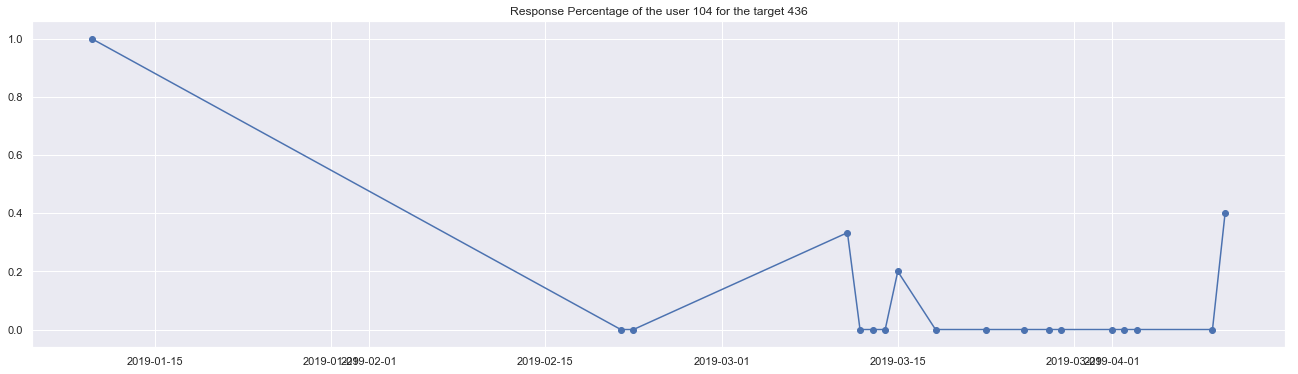

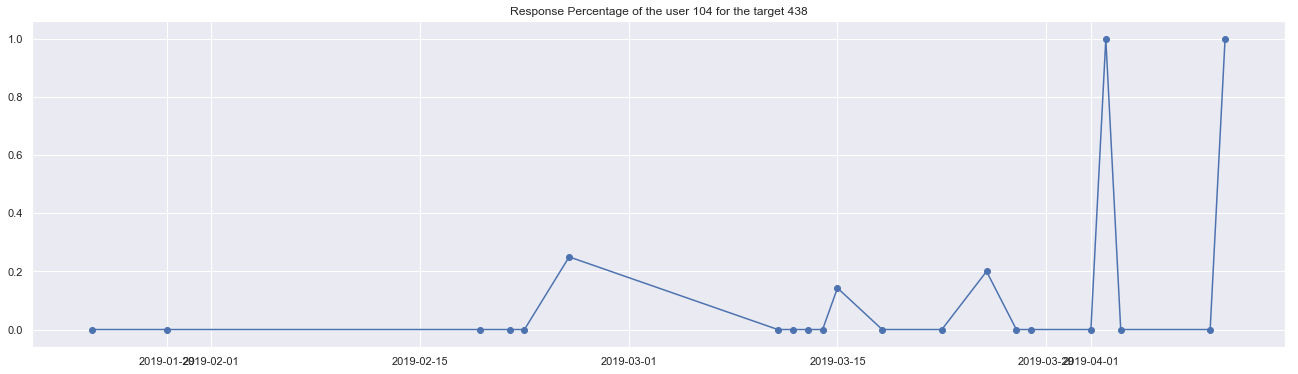

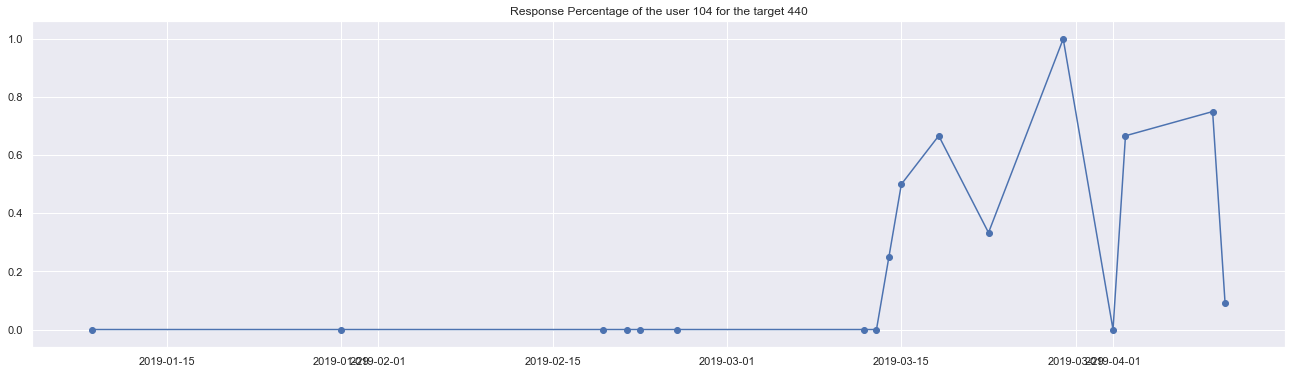

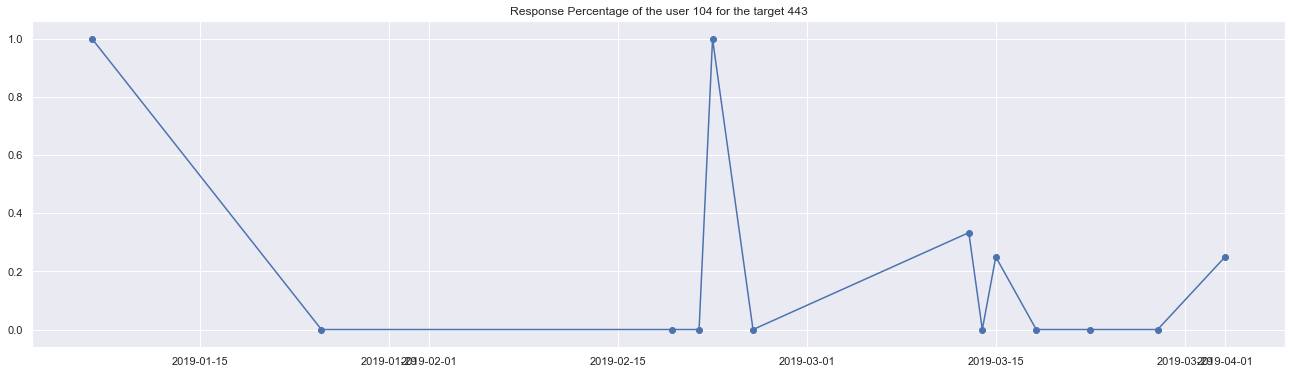

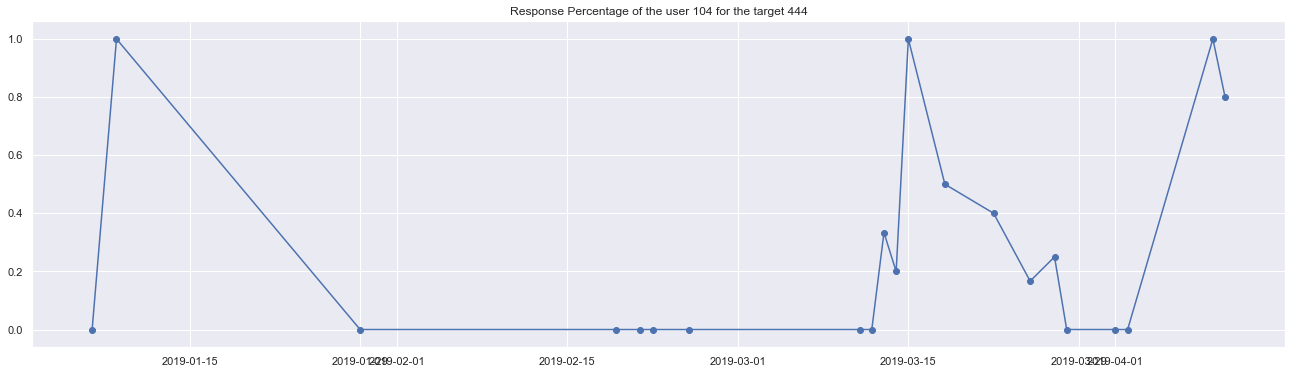

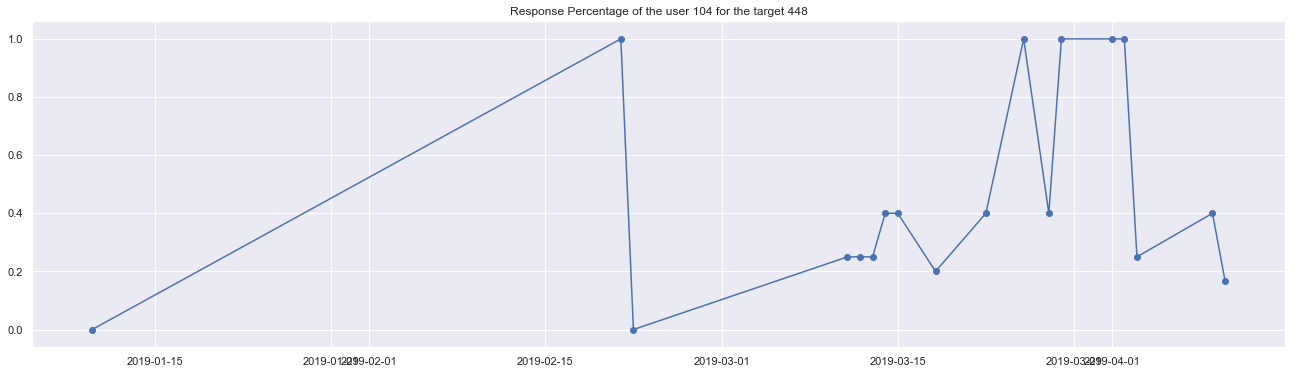

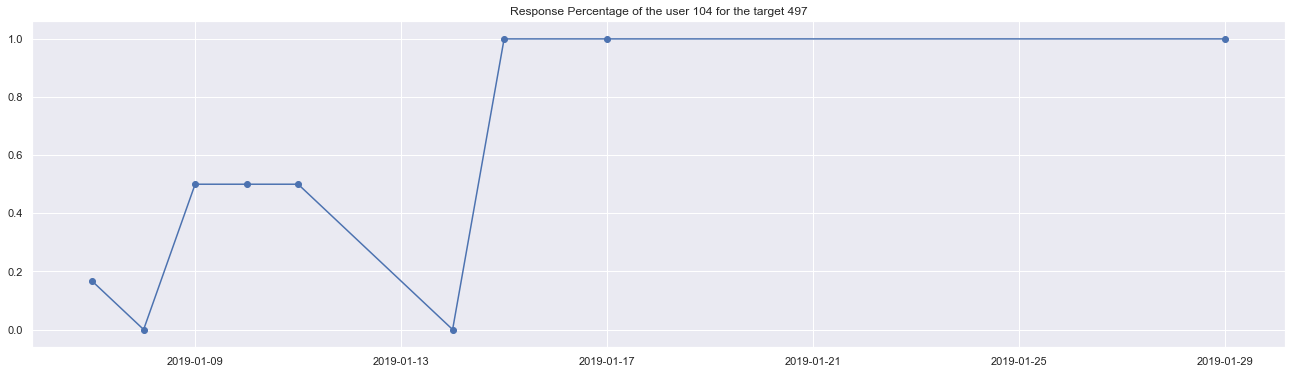

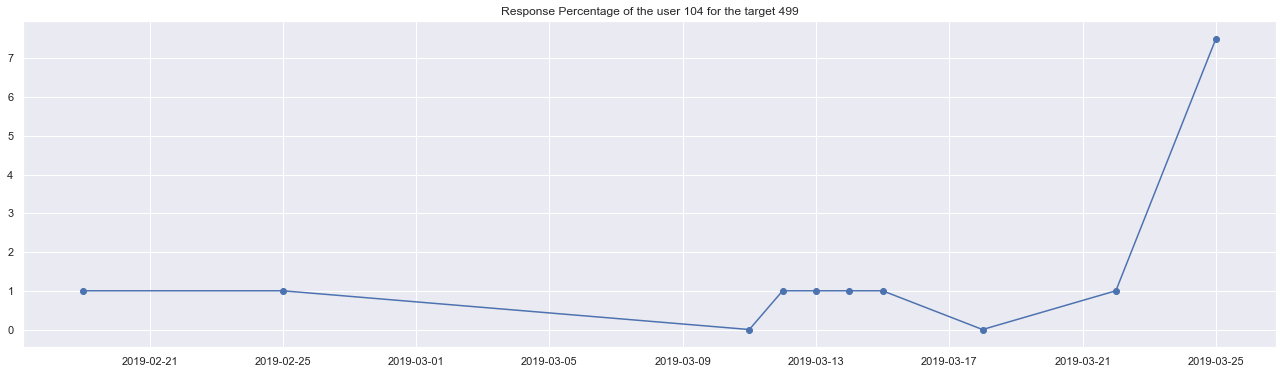

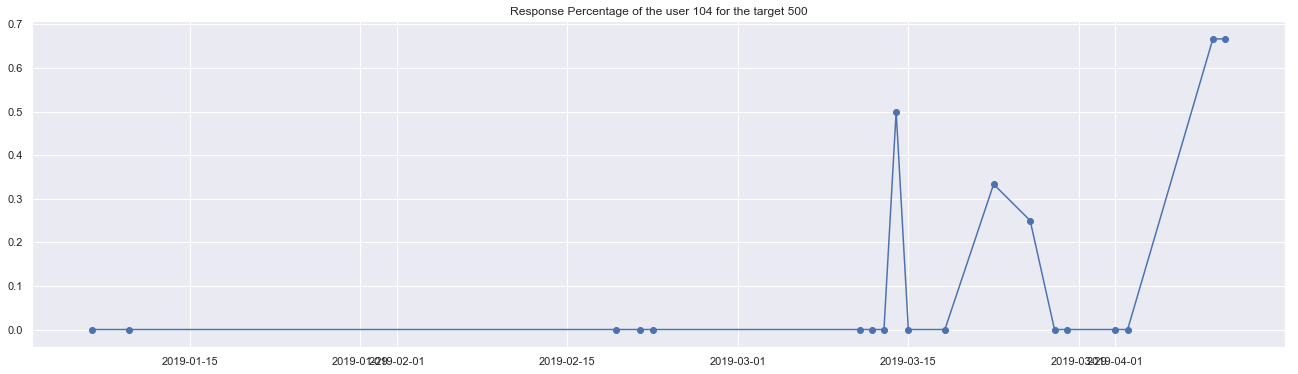

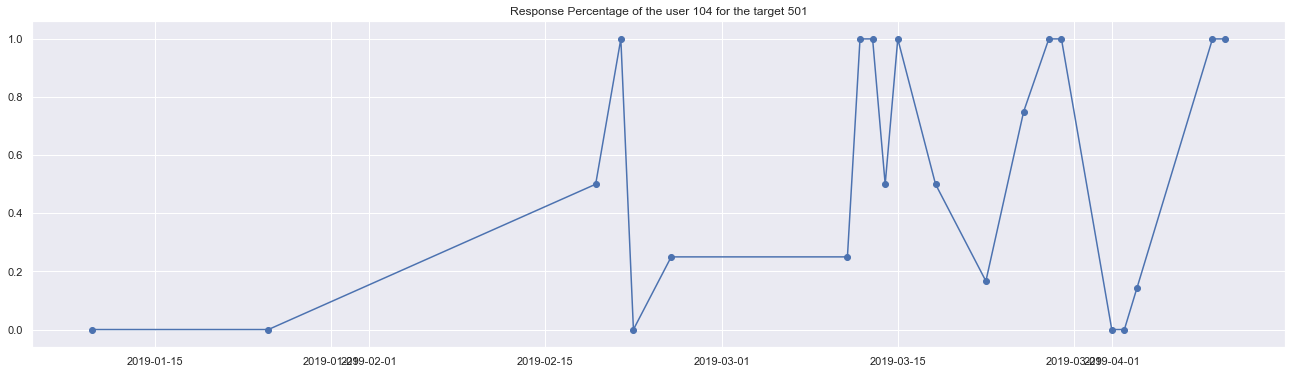

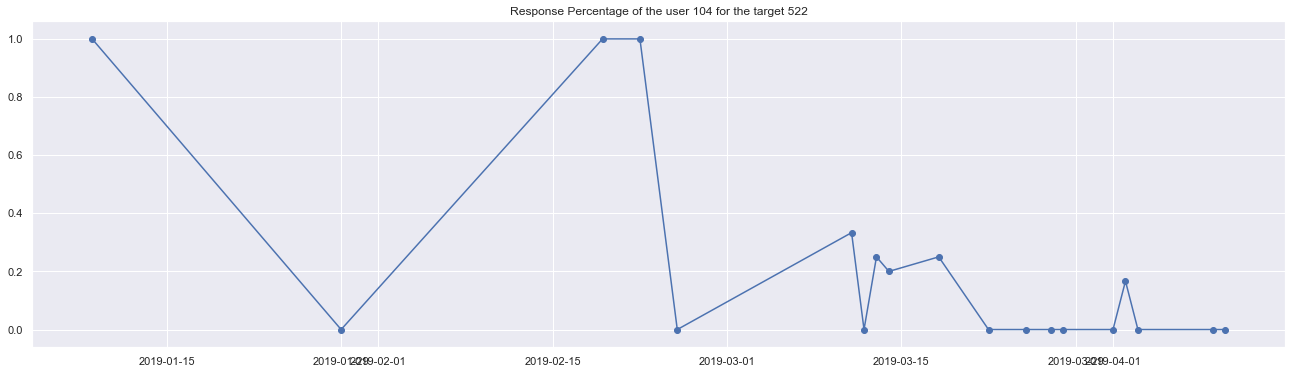

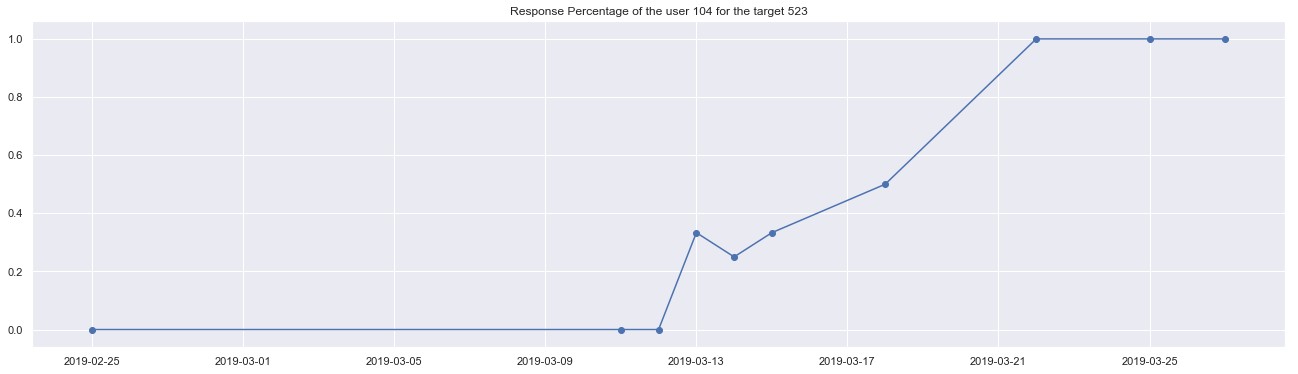

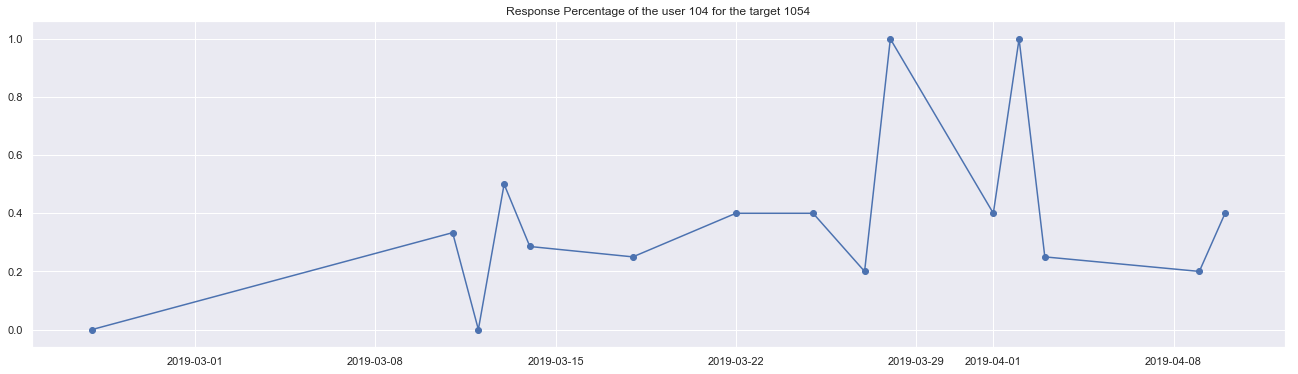

In [11]:
time_series_threshold = 5
time_series = {}
for target in user_targets:
    data_user_target = data_user.get_group(target).iloc[:,1:].sort_values(by=['session_date']).drop_duplicates(subset=['session_date', 'time', 'No_of_trails', 'correct_trails'], keep='last')
    data_user_target = data_user_target.groupby('session_date')['No_of_trails', 'correct_trails'].sum().reset_index().set_index('session_date')
    data_user_target['response_percentage'] = data_user_target['correct_trails'] / data_user_target['No_of_trails']
    target_series = pd.Series(data_user_target.response_percentage, index=data_user_target.index)
    if(len(target_series)>time_series_threshold):
        time_series[target] = target_series
        plt.figure(figsize=(20,6))
        plt.plot(target_series)
        plt.scatter(target_series.index, target_series)
        plt.title('Response Percentage of the user %d for the target %d' %(user, target))
        plt.grid(True)
        plt.show()

**Here we have strengthened our confidence for clustering since we observe a lot of correlation between learning performance of an individual**

**Beginning with the naive approach of using pca for the high-dimensional point equivalents of each time series**

In [12]:
pd.DataFrame.from_dict(time_series, orient='index')

,2019-01-10 00:00:00,2019-02-21 00:00:00,2019-02-22 00:00:00,2019-03-11 00:00:00,2019-03-12 00:00:00,2019-03-13 00:00:00,2019-03-14 00:00:00,2019-03-15 00:00:00,2019-03-18 00:00:00,2019-03-22 00:00:00,2019-03-25 00:00:00,2019-03-27 00:00:00,2019-03-28 00:00:00,2019-04-01 00:00:00,2019-04-02 00:00:00,2019-04-03 00:00:00,2019-04-09 00:00:00,2019-04-10 00:00:00,2019-01-24 00:00:00,2019-01-29 00:00:00,2019-02-19 00:00:00,2019-02-25 00:00:00,2019-01-09 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-11 00:00:00,2019-01-14 00:00:00,2019-01-15 00:00:00,2019-01-17 00:00:00
436,1.0,0.0,0.0,0.333333,0.00,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.000000,0.000000,0.000000,0.400000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
438,NaN,0.0,0.0,0.000000,0.00,0.000000,0.000000,0.142857,0.000000,0.000000,0.200000,0.00,0.0,0.00,1.000000,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
440,NaN,0.0,0.0,NaN,0.00,0.000000,0.250000,0.500000,0.666667,0.333333,NaN,NaN,1.0,0.00,0.666667,NaN,0.750000,0.090909,NaN,0.0,0.0,0.00,0.0,NaN,NaN,NaN,NaN,NaN,NaN
443,NaN,0.0,1.0,NaN,NaN,0.333333,0.000000,0.250000,0.000000,0.000000,NaN,0.00,NaN,0.25,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.00,NaN,1.000000,NaN,NaN,NaN,NaN,NaN
444,NaN,0.0,0.0,0.000000,0.00,0.333333,0.200000,1.000000,0.500000,0.400000,0.166667,0.25,0.0,0.00,0.000000,NaN,1.000000,0.800000,NaN,0.0,0.0,0.00,1.0,0.000000,NaN,NaN,NaN,NaN,NaN
448,0.0,1.0,0.0,0.250000,0.25,0.250000,0.400000,0.400000,0.200000,0.400000,1.000000,0.40,1.0,1.00,1.000000,0.250000,0.400000,0.166667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
497,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.5,0.166667,0.0,0.5,0.0,1.0,1.0
499,NaN,NaN,NaN,0.000000,1.00,1.000000,1.000000,1.000000,0.000000,1.000000,7.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
500,0.0,0.0,0.0,0.000000,0.00,0.000000,0.500000,0.000000,0.000000,0.333333,0.250000,0.00,0.0,0.00,0.000000,NaN,0.666667,0.666667,NaN,NaN,0.0,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
501,0.0,1.0,0.0,0.250000,1.00,1.000000,0.500000,1.000000,0.500000,0.166667,0.750000,1.00,1.0,0.00,0.000000,0.142857,1.000000,1.000000,0.0,NaN,0.5,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#finding out trend and seasonality parameters

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
trendParameters = []
seasonalityParameters = []
serialCorrelation = []
skewParameters = []
kurtosisParameters = []
for key in time_series.keys():
    series = pd.Series(time_series[key])
    result = seasonal_decompose(series, model='additive', freq=3)
    observed = result.observed
    detrended = result.observed - result.trend
    deseasonalised = result.observed - result.seasonal
    
    trendParameters.append(1 - (detrended.var() / observed.var()))
    seasonalityParameters.append(1-(deseasonalised.var() / observed.var()))
    serialCorrelation.append(series.autocorr())
    skewParameters.append(series.skew())
    kurtosisParameters.append(series.kurtosis())

In [14]:
childLearning = np.asarray([trendParameters, seasonalityParameters, serialCorrelation, skewParameters, kurtosisParameters]).T

In [16]:
pd.DataFrame(childLearning)

,0,1,2,3,4
0,0.778133,0.083471,-0.164090,2.925940,9.252603
1,0.473730,0.206865,-0.154793,2.694004,6.338956
2,0.459243,0.094211,0.267413,1.037780,-0.281968
3,0.275464,0.013417,-0.317386,1.740355,1.880553
4,0.523066,0.042862,0.195467,1.200530,-0.002083
5,0.395781,0.171444,0.060969,0.668439,-1.052447
6,0.542857,-0.080808,0.378332,0.028632,-1.586423
7,0.878309,0.123917,0.123718,2.934466,9.035237
8,0.656273,0.176443,0.352629,1.635794,1.265742
9,0.601871,0.021336,0.250453,-0.011476,-1.817832


In [20]:
pca = PCA(n_components=2)
pca.fit(childLearning)
childRepresentation = pca.fit_transform(childLearning)

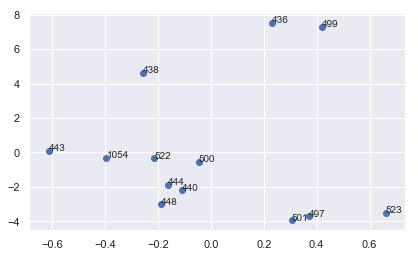

In [24]:
y, z = childRepresentation[:,0], childRepresentation[:,1]
n = time_series.keys()

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]))

**For futher reference:** https://www.researchgate.net/publication/228894373_A_scalable_method_for_time_series_clustering